In [46]:
import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

np.random.seed(1)

In [2]:
## from: https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df = df.drop(columns=['instance_weight']) ## not used for our analysis

categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [3]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)


In [4]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

In [5]:
## test set for feature selection
selection_df = df.sample(frac = .05)

In [6]:
### Preprocess the data
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns
X_selection = selection_df.drop(target, axis=1)
y_selection = selection_df[target]
preprocessor = preprocess_pipeline(numeric_features, categorical_features)
X_selection_preprocessed = preprocessor.fit_transform(X_selection)

In [7]:
### Make a list of all the columns after one hot encoding
ohe = preprocessor['preprocessor'].named_transformers_['cat']['onehot']
cat_processed = ohe.get_feature_names(X_selection[categorical_features].columns)
all_processed_cols = np.concatenate((numeric_features, cat_processed), axis=0)

Optimal number of features : 159


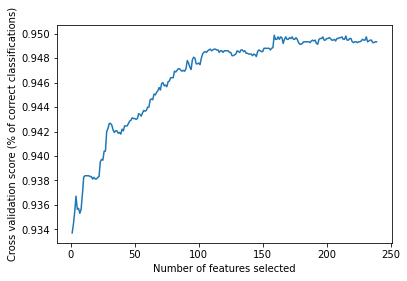

In [8]:
### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv = RFECV(clf, step=1, cv=5)
rfecv.fit(X_selection_preprocessed, y_selection)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [28]:
### Show all selected features
selected_features = all_processed_cols[rfecv.support_]
print(selected_features)
X = df.drop(target, axis=1)
y = df[target]
X_preprocessed = preprocessor.fit_transform(X)
X_selected = X_preprocessed.tocsr()[:,rfecv.support_] #index columns of sparse matrix

['age' 'capital_gains' 'capital_losses' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Federal government'
 'class_worker_ Local government' 'class_worker_ Not in universe'
 'class_worker_ Self-employed-incorporated'
 'class_worker_ State government' 'class_worker_ Without pay'
 'det_ind_code_0' 'det_ind_code_1' 'det_ind_code_3' 'det_ind_code_5'
 'det_ind_code_6' 'det_ind_code_7' 'det_ind_code_11' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_17'
 'det_ind_code_18' 'det_ind_code_20' 'det_ind_code_21' 'det_ind_code_22'
 'det_ind_code_23' 'det_ind_code_24' 'det_ind_code_25' 'det_ind_code_26'
 'det_ind_code_27' 'det_ind_code_28' 'det_ind_code_29' 'det_ind_code_31'
 'det_ind_code_35' 'det_ind_code_36' 'det_ind_code_37' 'det_ind_code_38'
 'det_ind_code_44' 'det_ind_code_46' 'det_ind_code_48' 'det_ind_code_50'
 'det_occ_code_2' 'det_occ_code_5' 'det_occ_code_6' 'det_occ_code_7'
 'det_occ_code_10' 'det_occ_code_11' 'det_occ_code_12' 'det_oc

In [31]:
#### Using the classification_pipeline function Logistic regression
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    'max_iter': [99999],
}

CV = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV.fit(X_selected, y)
    
print('Best Score: {s}'.format(s=CV.best_score_))
print('Best Parameters: {p}'.format(p=CV.best_params_))  

Best Score: 0.951855262435273
Best Parameters: {'class_weight': None, 'max_iter': 99999}


In [41]:
classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [10,100,1000],
}

CV = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV.fit(X_selected, y)

print('Best Score: {s}'.format(s=CV.best_score_))
print('Best Parameters: {p}'.format(p=CV.best_params_)) 



KeyboardInterrupt: 